In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/data/user/jbourbeau/metaprojects/icerec/trunk/build/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/opt/rh/devtoolset-2/root/usr/lib64/python2.7/site-packages',
 '/opt/rh/devtoolset-2/root/usr/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/home/jbourbeau/cr-composition',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensc

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import argparse
import seaborn.apionly as sns

# from icecube import ShowerLLH

import composition as comp
import composition.analysis.plotting as plotting
import composition.analysis.data_functions as data

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 145932
number testing events = 62543


In [5]:
MC_log_energy = df.MC_log_energy.values
reco_log_energy = df.lap_log_energy.values

/home/jbourbeau/cr-composition/composition/analysis/plotting.py:67: RuntimeWarning: divide by zero encountered in log10
  h = np.log10(h)


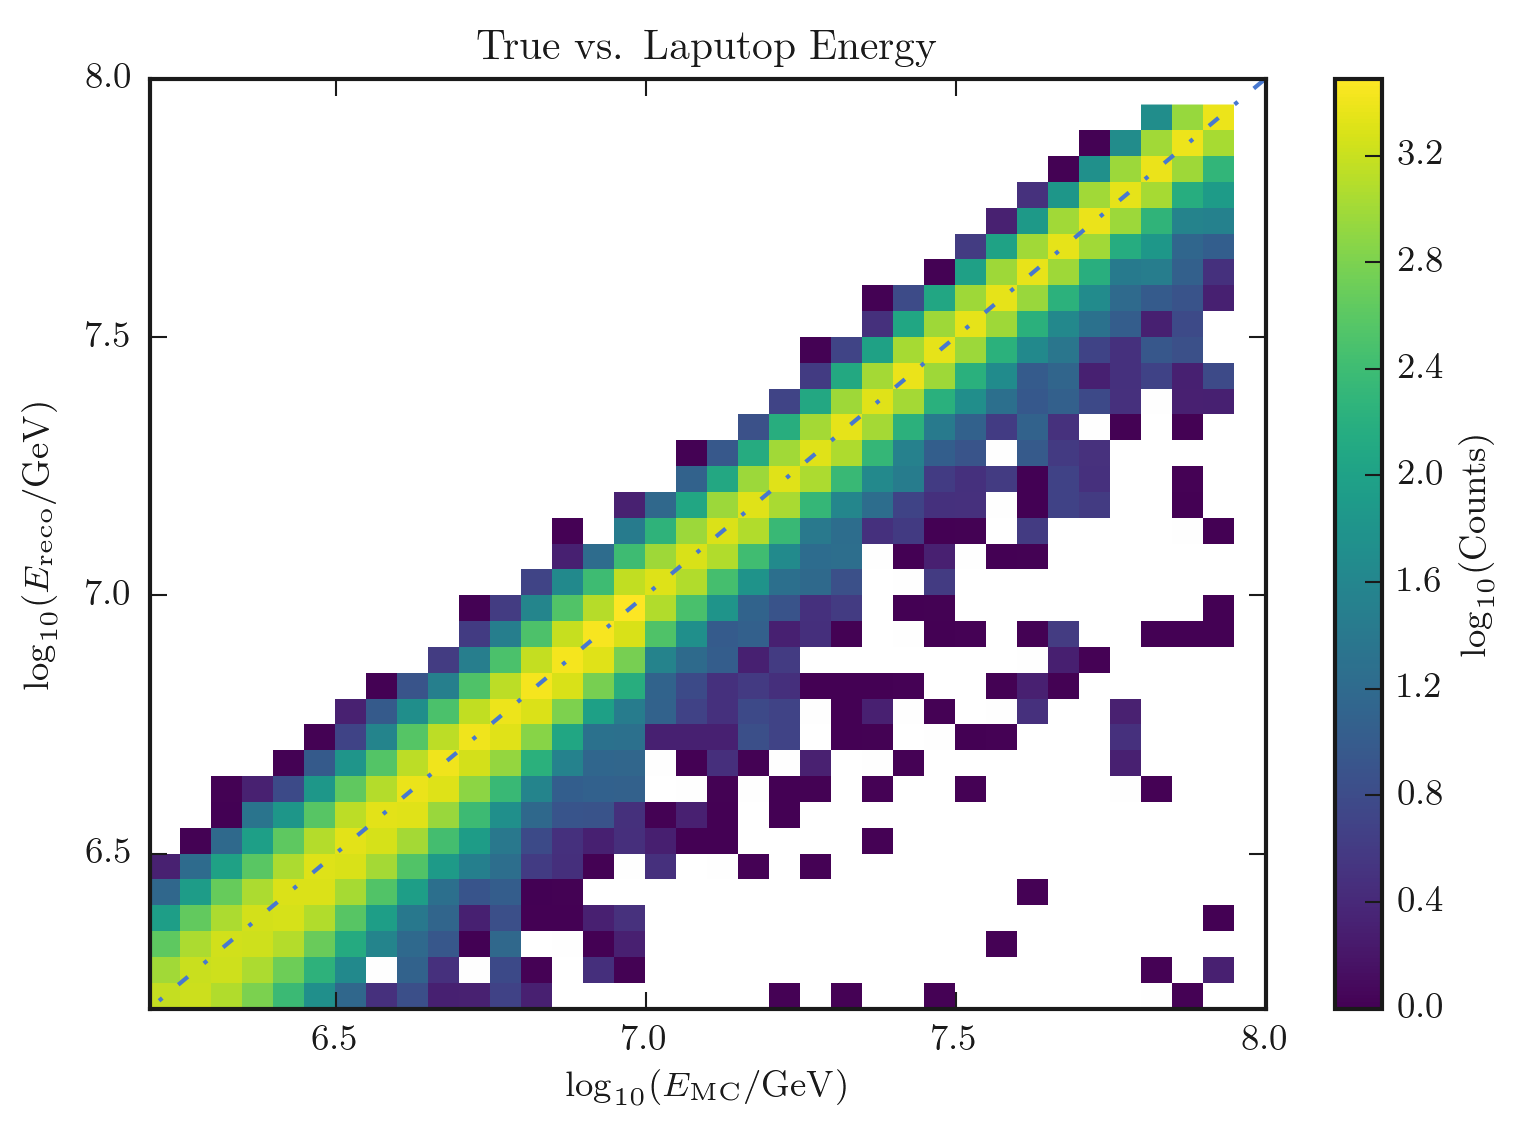

In [6]:
energy_bins = np.arange(6.2, 8, 0.05)
fig, ax = plt.subplots()
plotting.histogram_2D(MC_log_energy, reco_log_energy, energy_bins, log_counts=True)
plt.plot([0,10], [0,10], marker='None', linestyle='-.')
plt.xlim([6.2, 8])
plt.ylim([6.2, 8])
plt.xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
plt.ylabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
plt.title('True vs. Laputop Energy')
plt.show()

In [7]:
energy_res = reco_log_energy - MC_log_energy
energy_bins = np.linspace(6.2, 8, 30)
energy_bins = np.arange(6.2, 8.1, 0.1)
bin_centers, bin_medians, error = comp.analysis.data_functions.get_medians(MC_log_energy, energy_res, energy_bins)

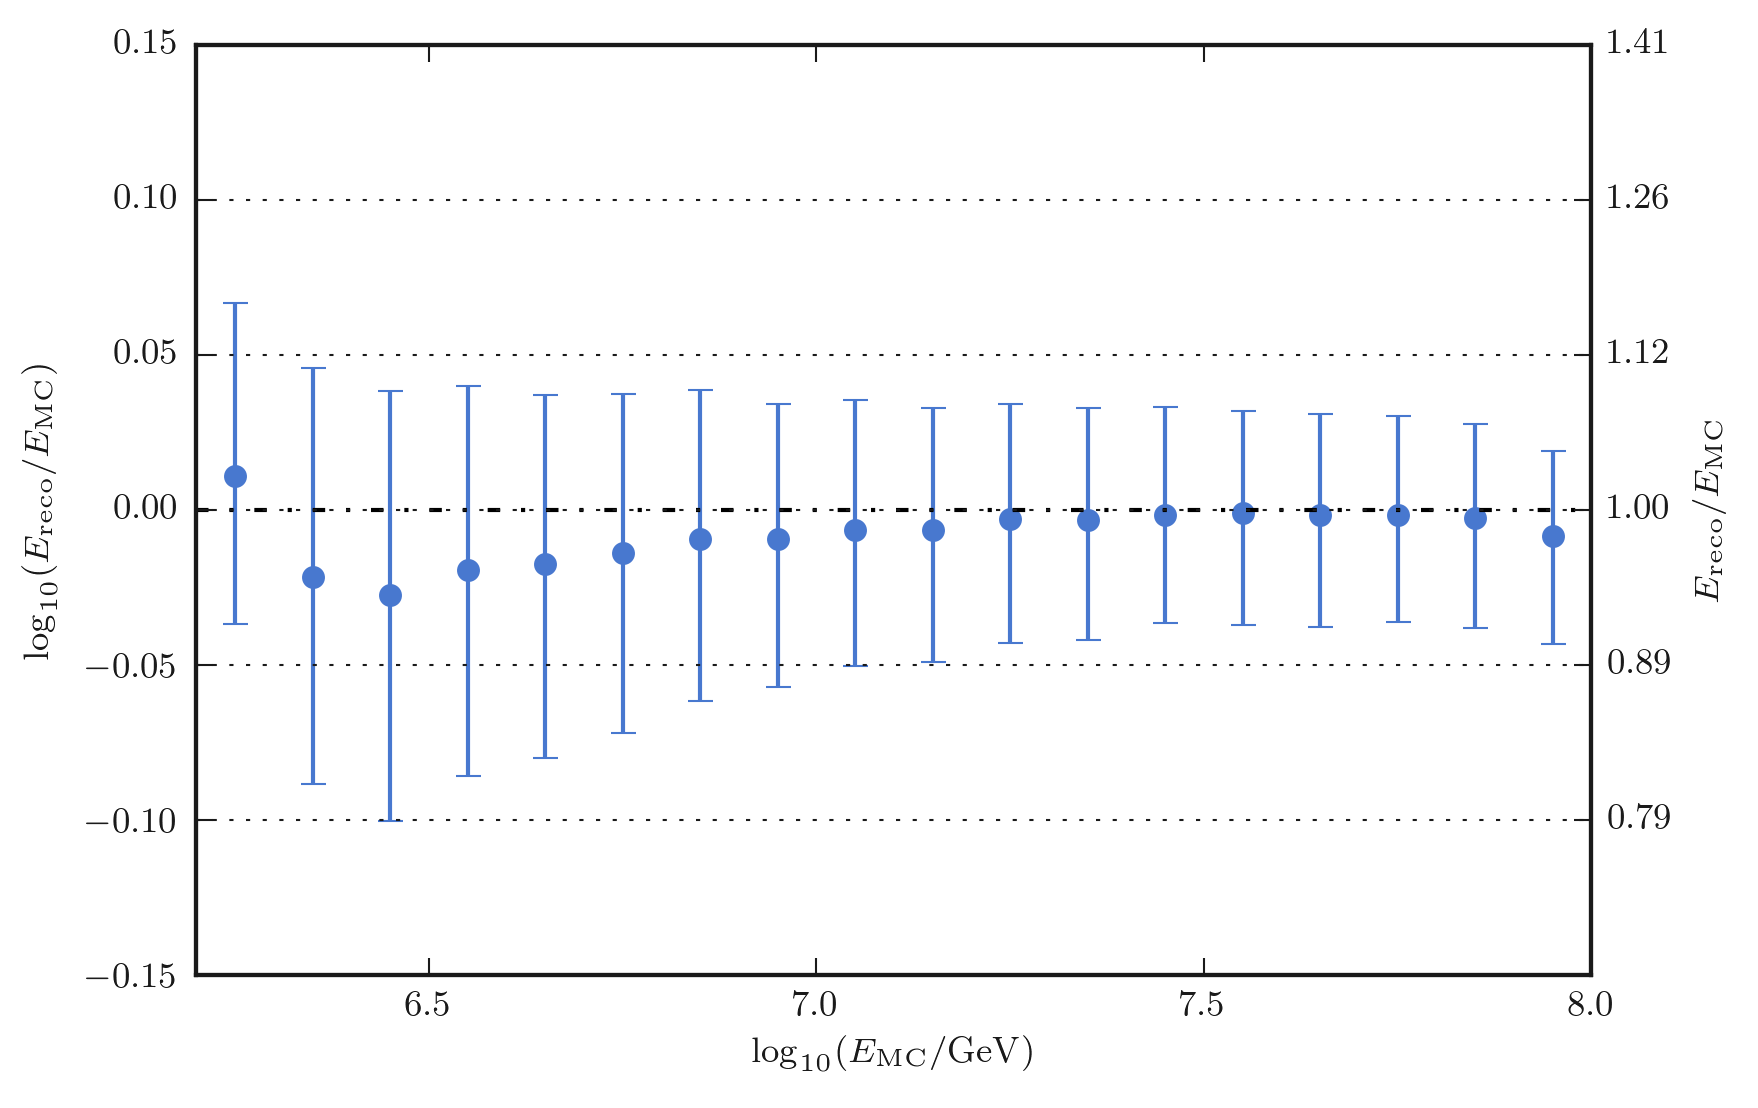

In [8]:
fig, ax = plt.subplots()
ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.')
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
ax.set_ylim([-0.15, 0.15])
ax2 = ax.twinx()
ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
ax2.set_ylim(list(ax.get_ylim()))
# ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.show()

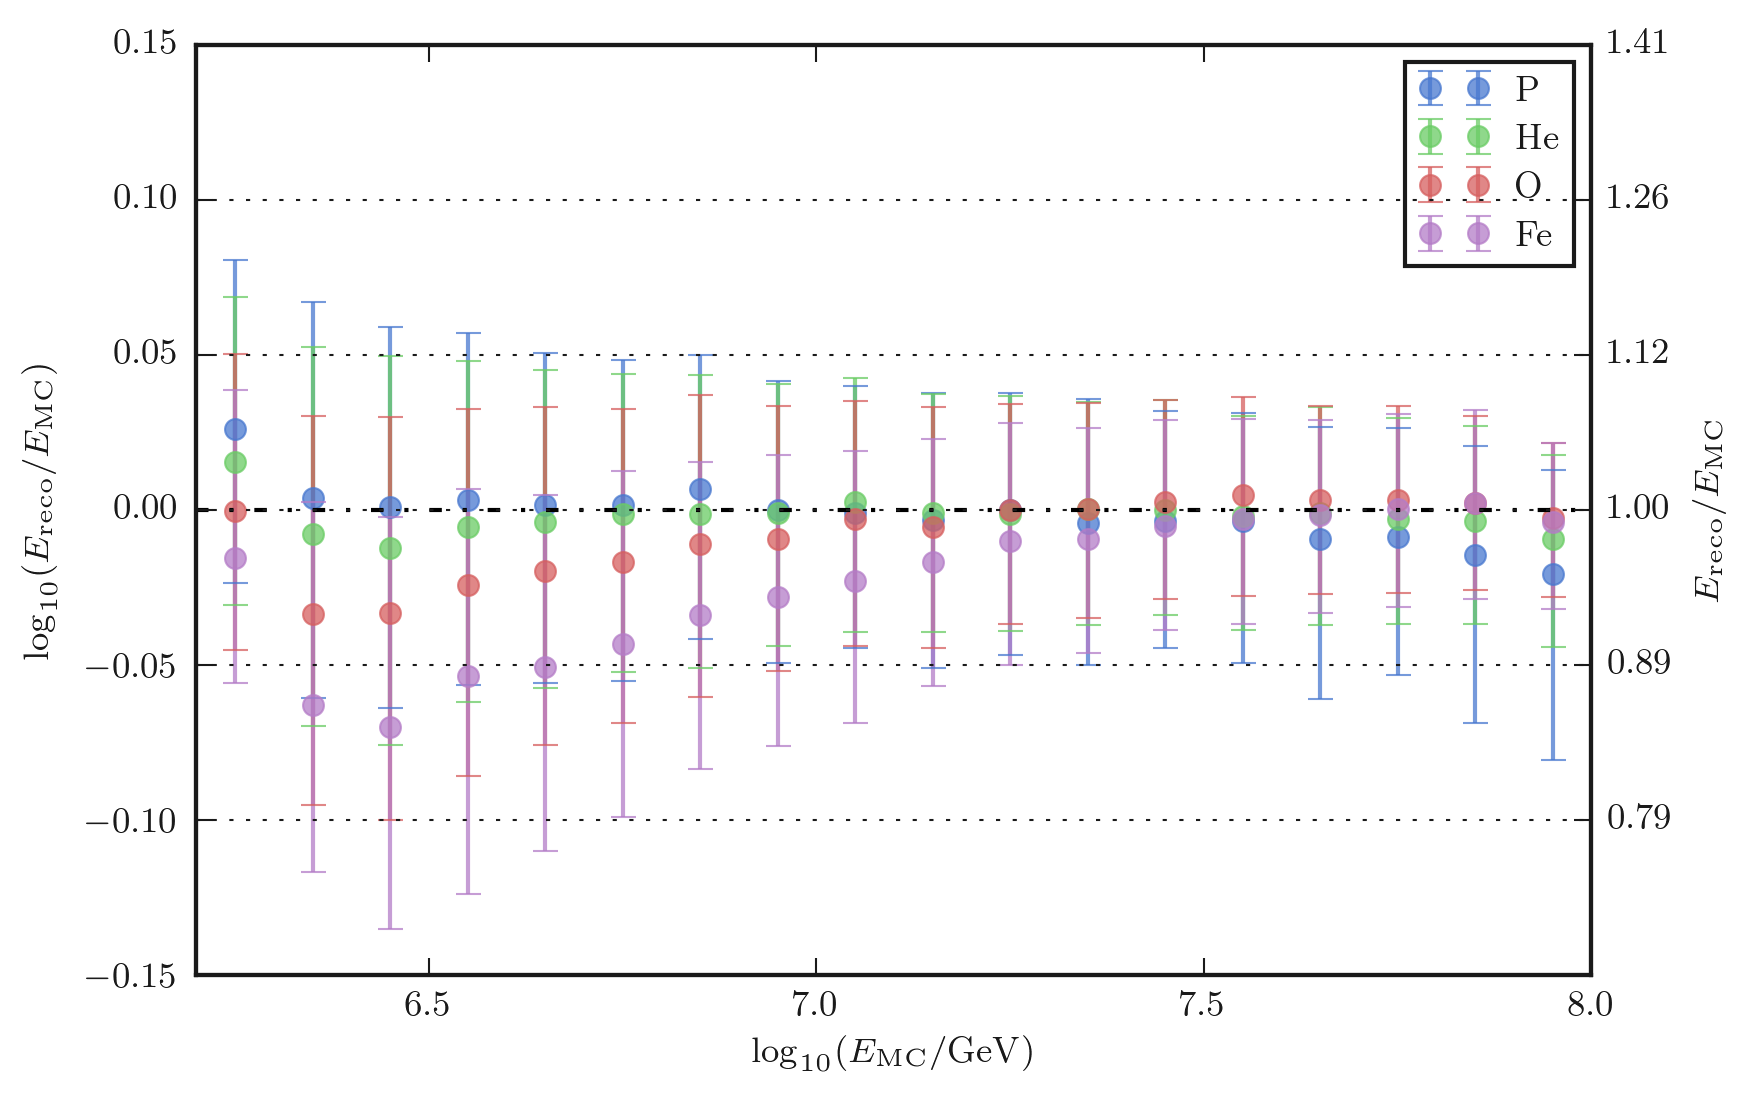

In [9]:
energy_res = reco_log_energy - MC_log_energy
energy_bins = np.linspace(6.2, 8, 25)
energy_bins = np.arange(6.2, 8.1, 0.1)
comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
# Construct MC composition masks
# MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask = (df['MC_comp'] == composition).values
    bin_centers, bin_medians, error = comp.analysis.data_functions.get_medians(MC_log_energy[MC_comp_mask],
                                                                               energy_res[MC_comp_mask],
                                                                               energy_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', label=composition, alpha=0.75)
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
ax.set_ylim([-0.15, 0.15])
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
ax2.set_ylim(list(ax.get_ylim()))
plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.show()

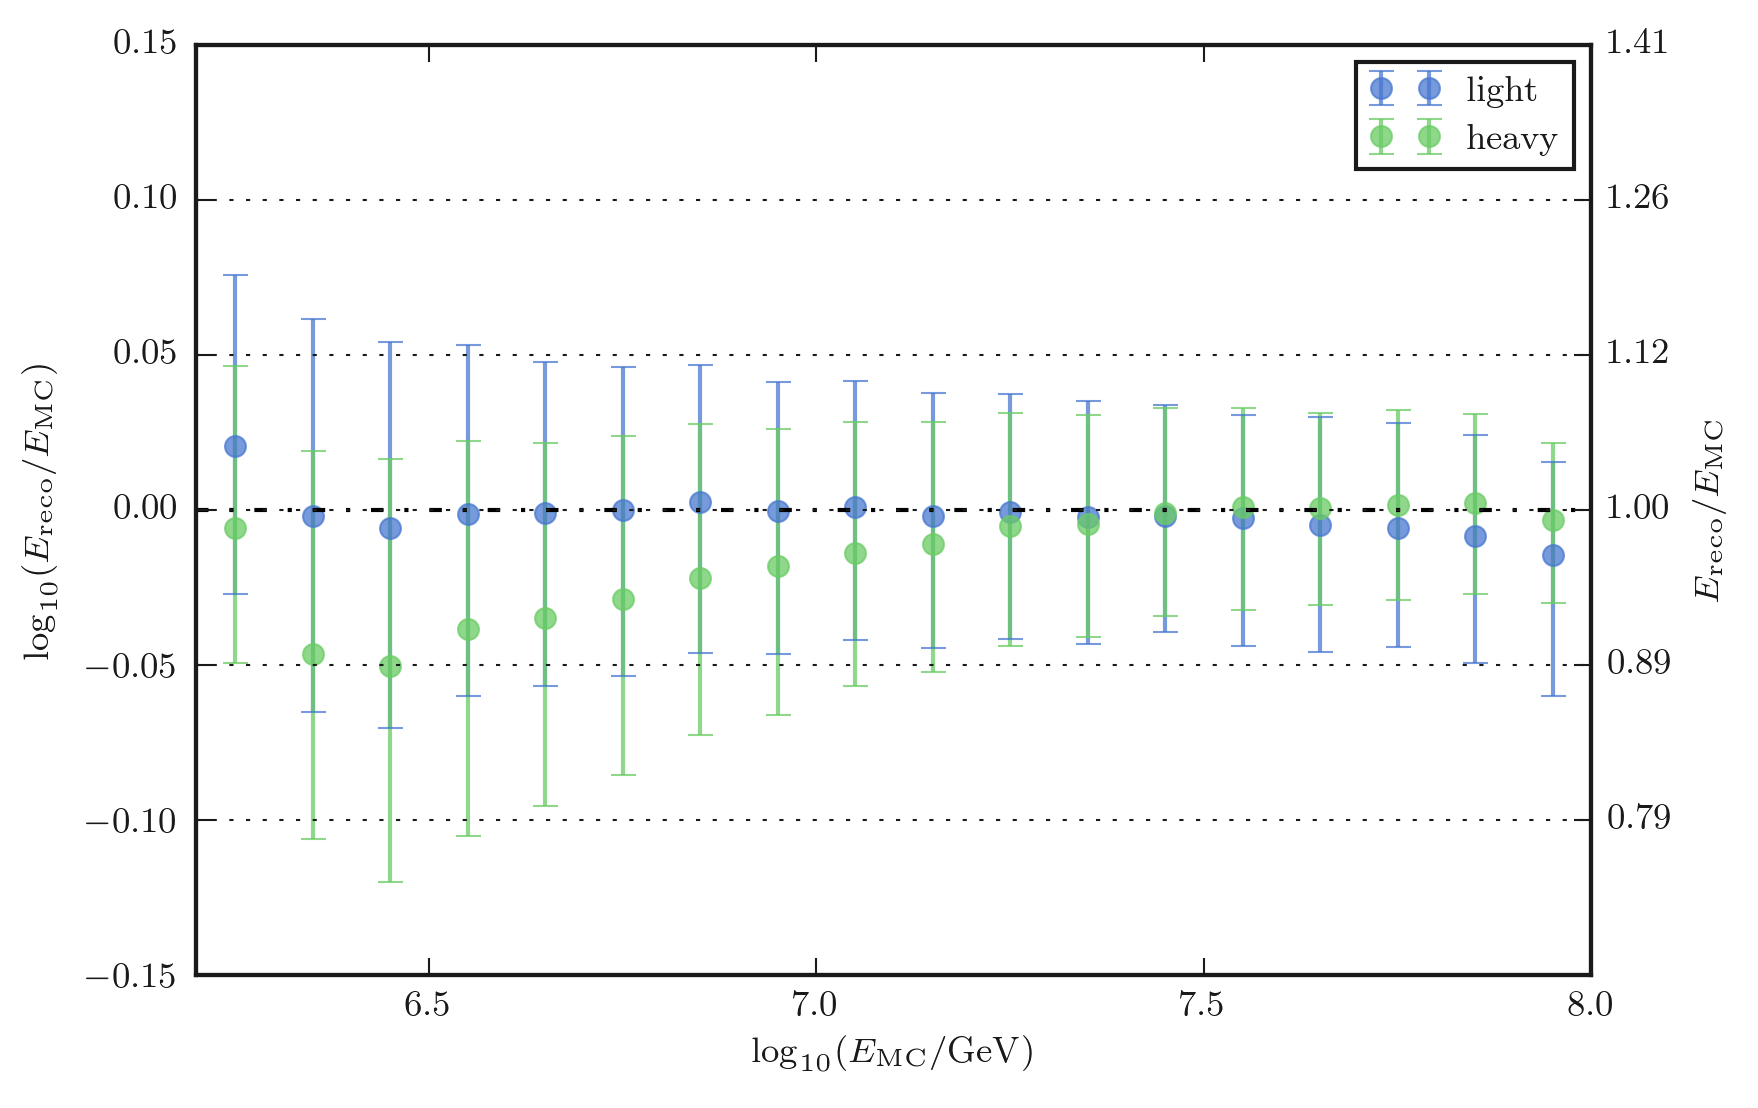

In [10]:
energy_res = reco_log_energy - MC_log_energy
energy_bins = np.linspace(6.2, 8, 25)
energy_bins = np.arange(6.2, 8.1, 0.1)
fig, ax = plt.subplots()
# Construct MC composition masks
# MC_comp_mask = {}
for composition in ['light', 'heavy']:
    MC_comp_mask = (df['MC_comp_class'] == composition).values
    bin_centers, bin_medians, error = comp.analysis.data_functions.get_medians(MC_log_energy[MC_comp_mask],
                                                                               energy_res[MC_comp_mask],
                                                                               energy_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', label=composition, alpha=0.75)
# ax.errorbar(bin_centers, bin_medians_iron, yerr=error_iron, marker='.', label='Iron', alpha=1)
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
ax.set_ylim([-0.15, 0.15])
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
ax2.set_ylim(list(ax.get_ylim()))
# ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.show()

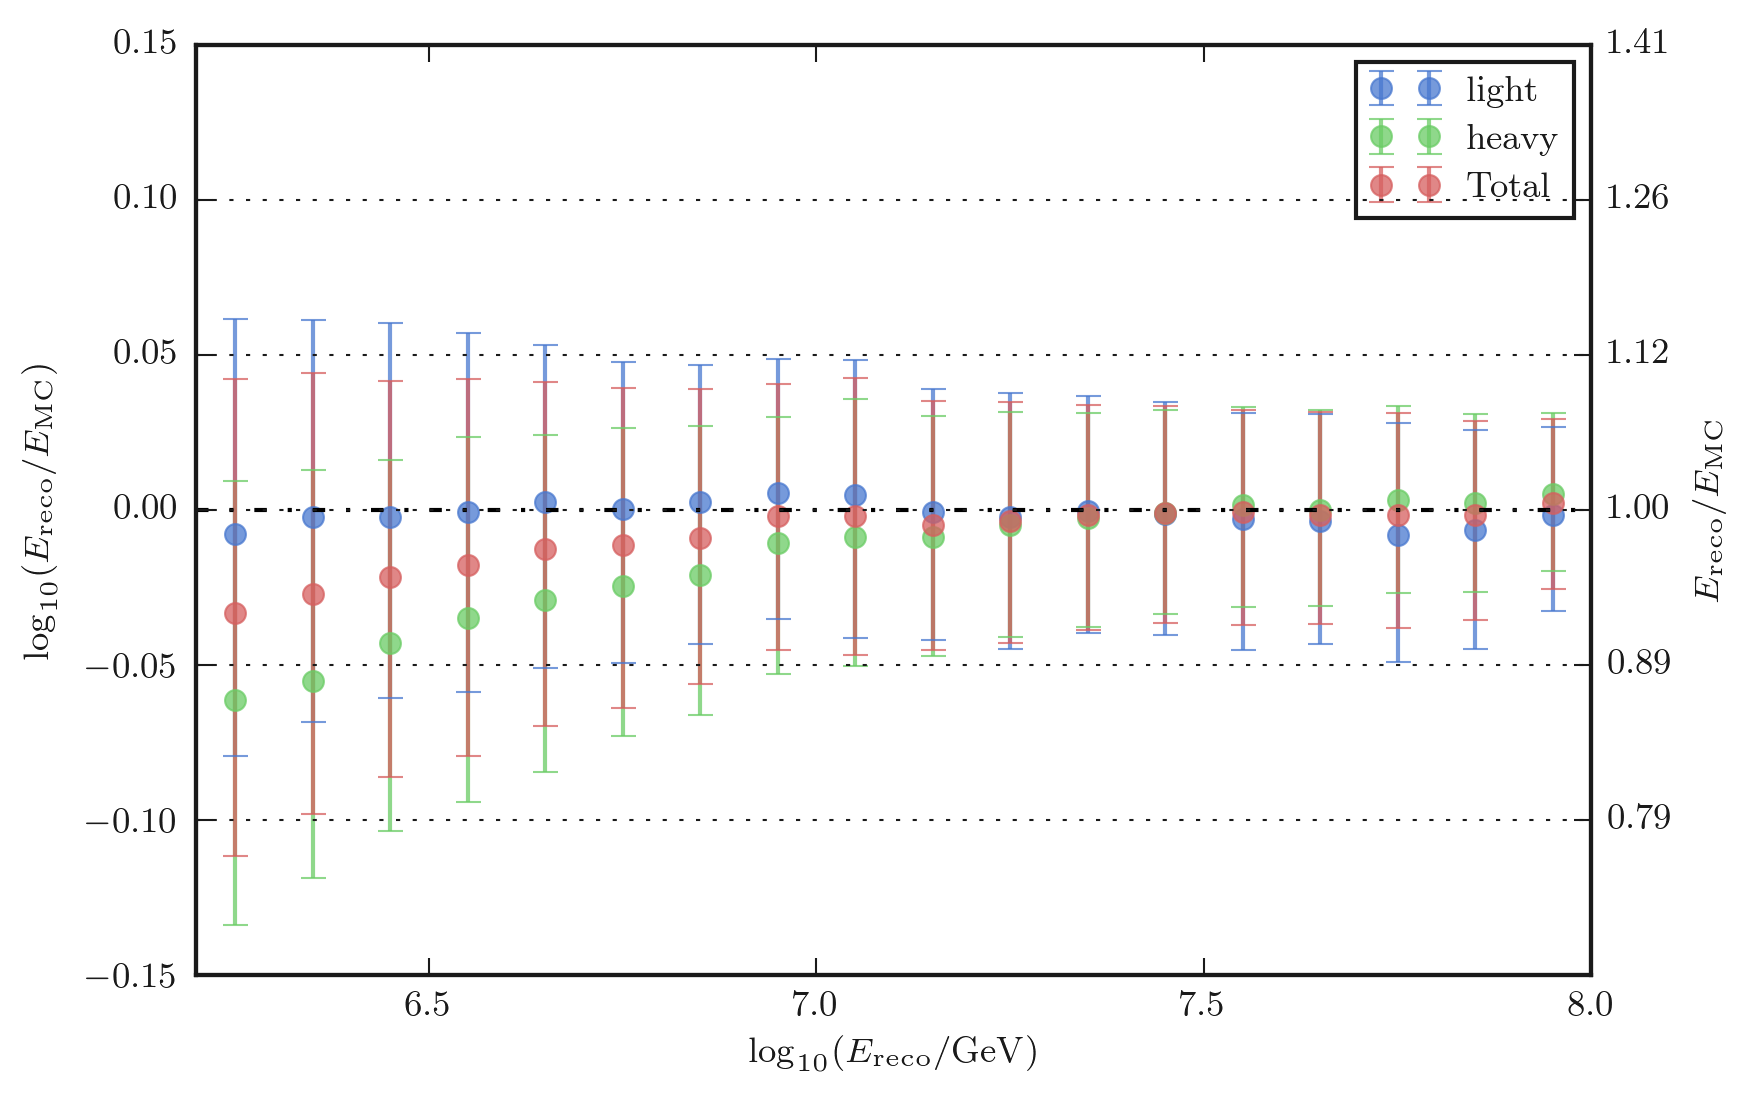

In [12]:
energy_res = reco_log_energy - MC_log_energy
energy_bins = np.linspace(6.2, 8, 25)
energy_bins = np.arange(6.2, 8.1, 0.1)
fig, ax = plt.subplots()
# Construct MC composition masks
# MC_comp_mask = {}
for composition in ['light', 'heavy']:
    MC_comp_mask = (df['MC_comp_class'] == composition).values
    bin_centers, bin_medians, error = comp.analysis.data_functions.get_medians(reco_log_energy[MC_comp_mask],
                                                                               energy_res[MC_comp_mask],
                                                                               energy_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', label=composition, alpha=0.75)
bin_centers, bin_medians, error = comp.analysis.data_functions.get_medians(reco_log_energy,
                                                                           energy_res,
                                                                           energy_bins)
ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', label='Total', alpha=0.75)
# ax.errorbar(bin_centers, bin_medians_iron, yerr=error_iron, marker='.', label='Iron', alpha=1)
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
ax.set_ylim([-0.15, 0.15])
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
ax2.set_ylim(list(ax.get_ylim()))
# ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.show()

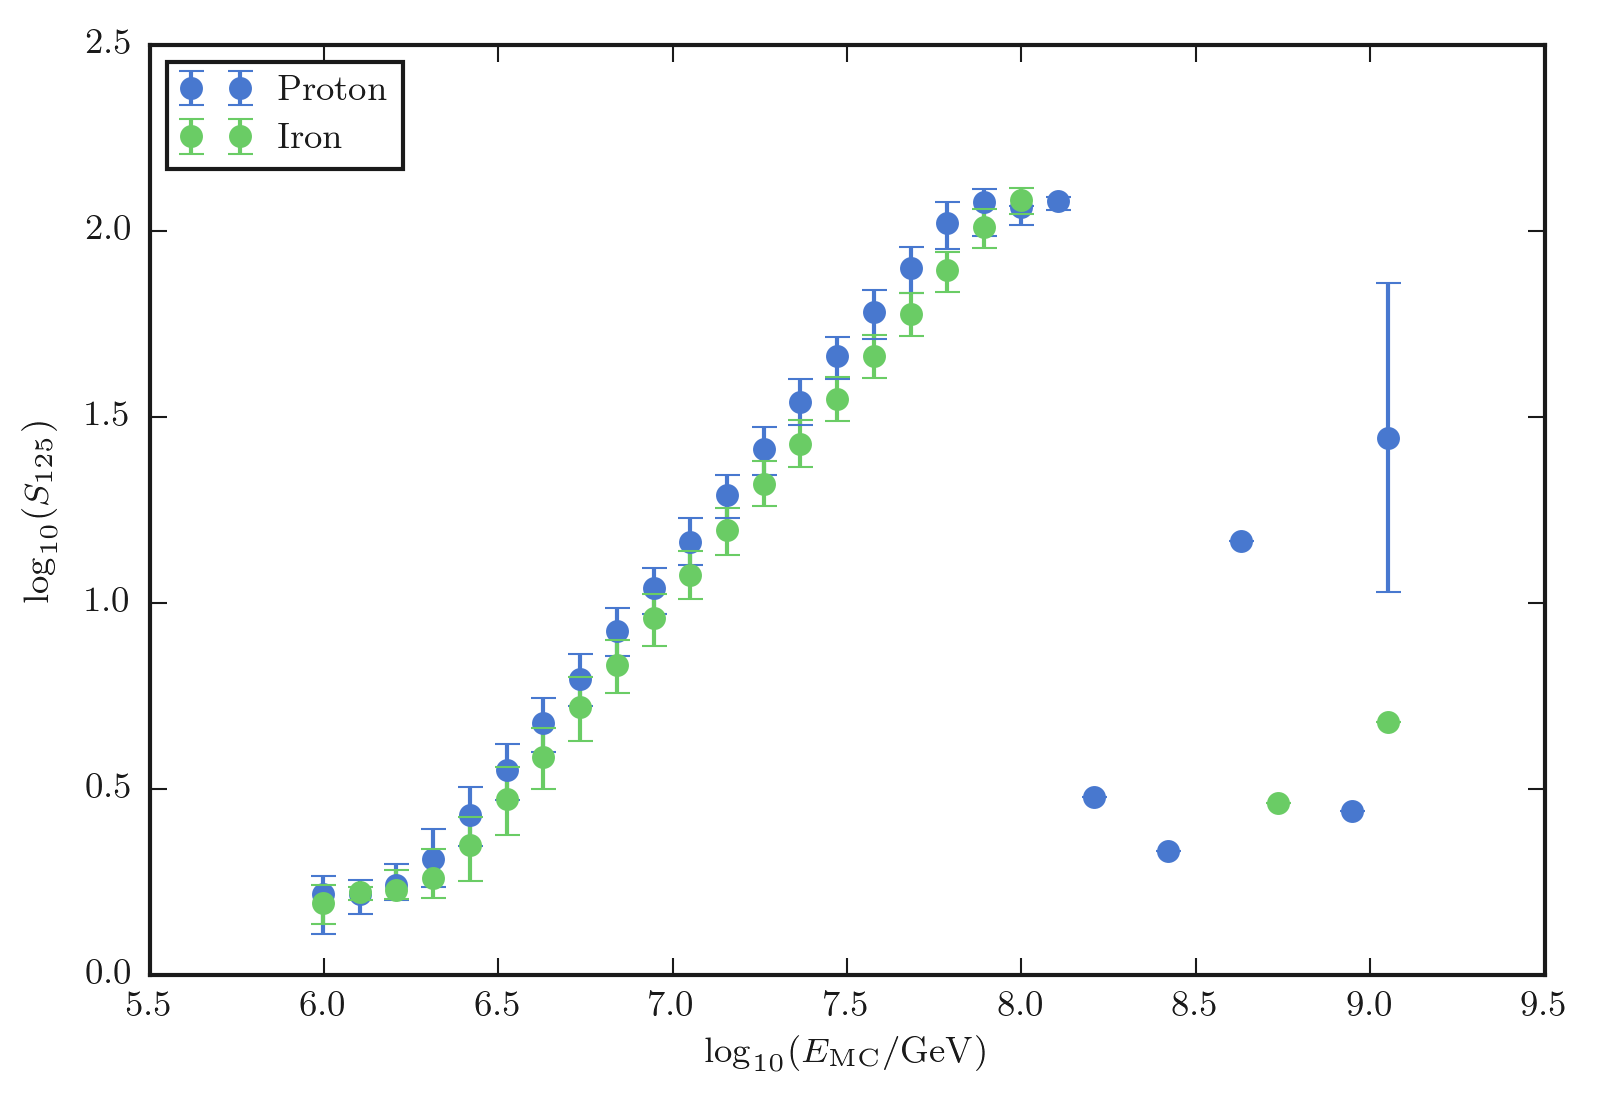

In [11]:
MC_proton_mask = (df['MC_comp'] == 'P').values
MC_iron_mask = (df['MC_comp'] == 'Fe').values
log_s125 = df['log_s125'].values
energy_bins = np.linspace(5.5, 9.5, 30)
energy_bins = 30
bin_centers, bin_medians_proton, error_proton = comp.analysis.data_functions.get_medians(MC_log_energy[MC_proton_mask],
                                                                                         log_s125[MC_proton_mask],
                                                                                         energy_bins)
bin_centers, bin_medians_iron, error_iron = comp.analysis.data_functions.get_medians(MC_log_energy[MC_iron_mask],
                                                                                     log_s125[MC_iron_mask],
                                                                                     energy_bins)
fig, ax = plt.subplots()
ax.errorbar(bin_centers, bin_medians_proton, yerr=error_proton, marker='.', label='Proton')
ax.errorbar(bin_centers, bin_medians_iron, yerr=error_iron, marker='.', label='Iron')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(S_{125})$')
plt.legend(loc=2)
plt.show()

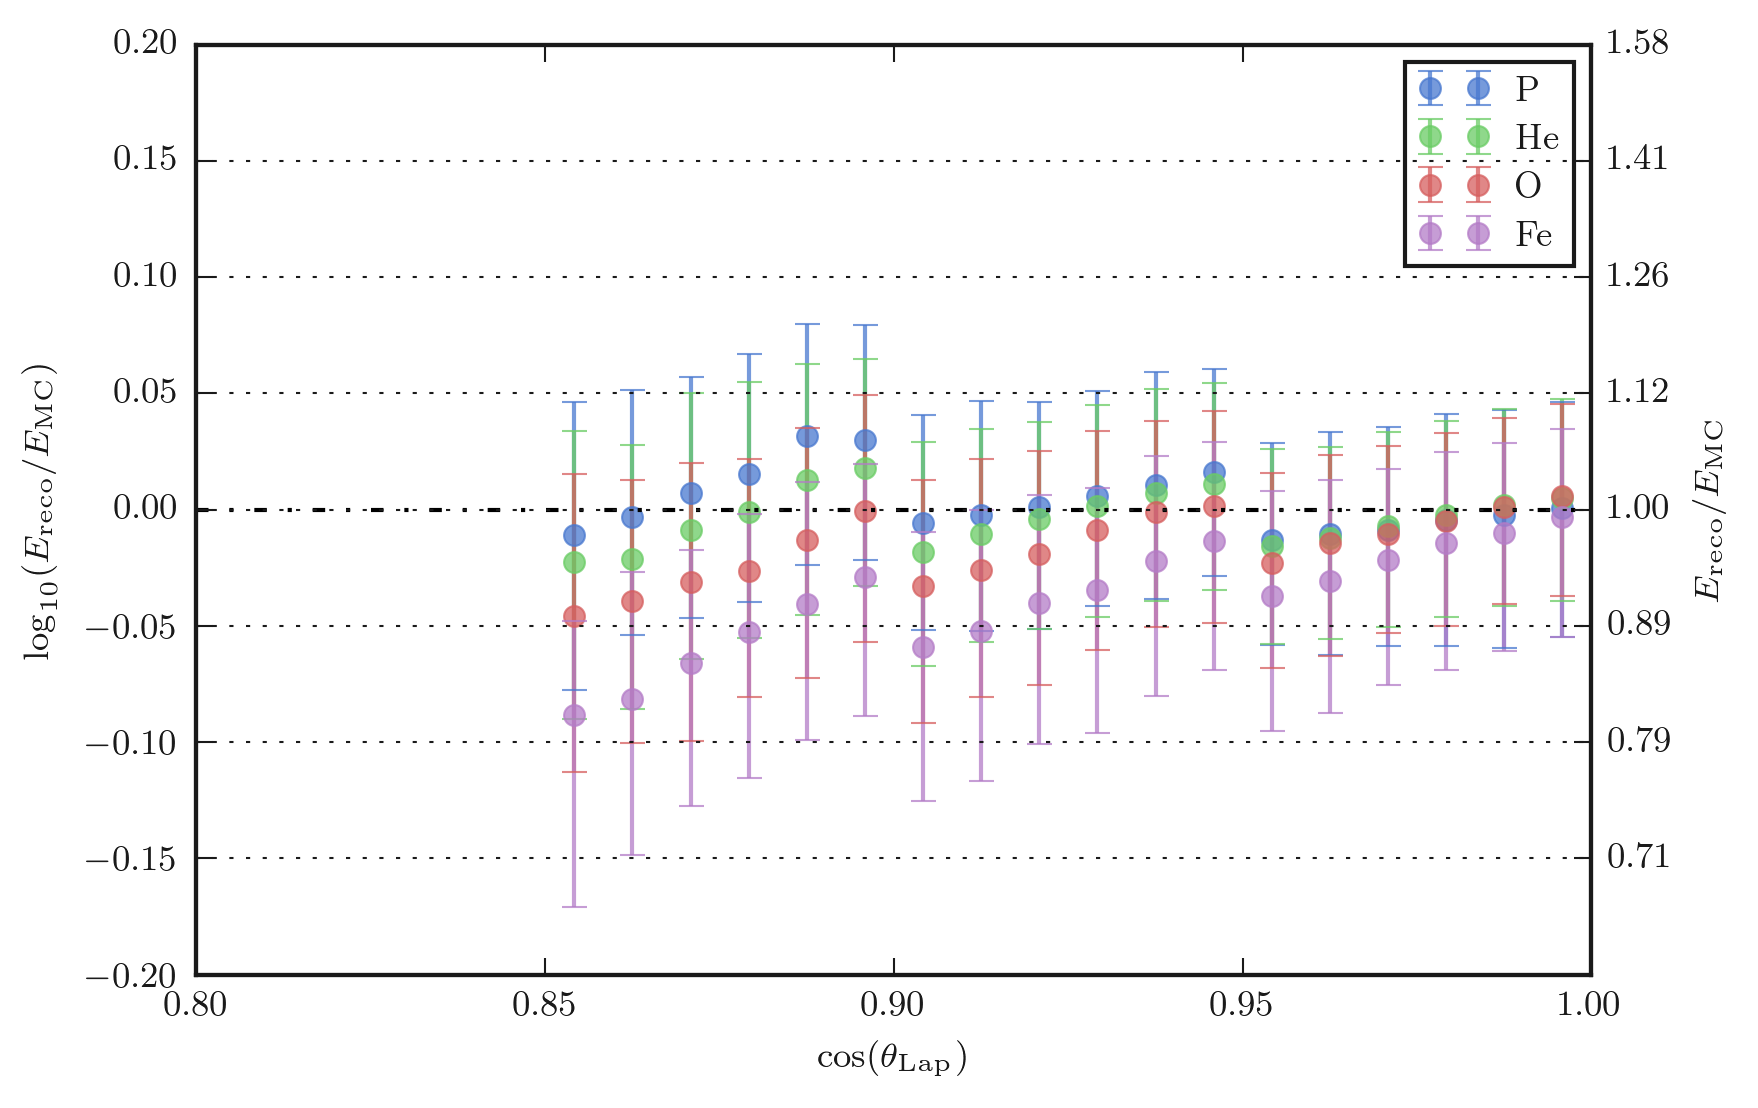

In [12]:
cos_zenith = np.cos(df['lap_zenith'].values)
MC_proton_mask = (df['MC_comp'] == 'P').values
MC_iron_mask = (df['MC_comp'] == 'Fe').values
zenith_bins = np.linspace(0.8, 1.0, 25)
comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
# Construct MC composition masks
for composition in comp_list:
    MC_comp_mask = (df['MC_comp'] == composition).values
    bin_centers, bin_medians, error = comp.analysis.data_functions.get_medians(cos_zenith[MC_comp_mask],
                                                                               energy_res[MC_comp_mask],
                                                                               zenith_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', label=composition, alpha=0.75)
ax.axhline(0, marker='None', linestyle='-.')
# LLH_bins = ShowerLLH.LLHBins('logdist')
# for x in LLH_bins.bins['Z']:
#     ax.axvline(np.cos(x), marker='None', linestyle='--', color='gray')
ax.set_xlabel('$\cos(\\theta_{\mathrm{Lap}})$')
ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
ax.set_xlim([0.8, 1.0])
ax.set_ylim([-0.2, 0.2])
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
ax2.set_ylim(list(ax.get_ylim()))
plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.show()

[ 0.82453333  0.85377778  0.88302222  0.91226667  0.94151111  0.97075556
  1.        ]


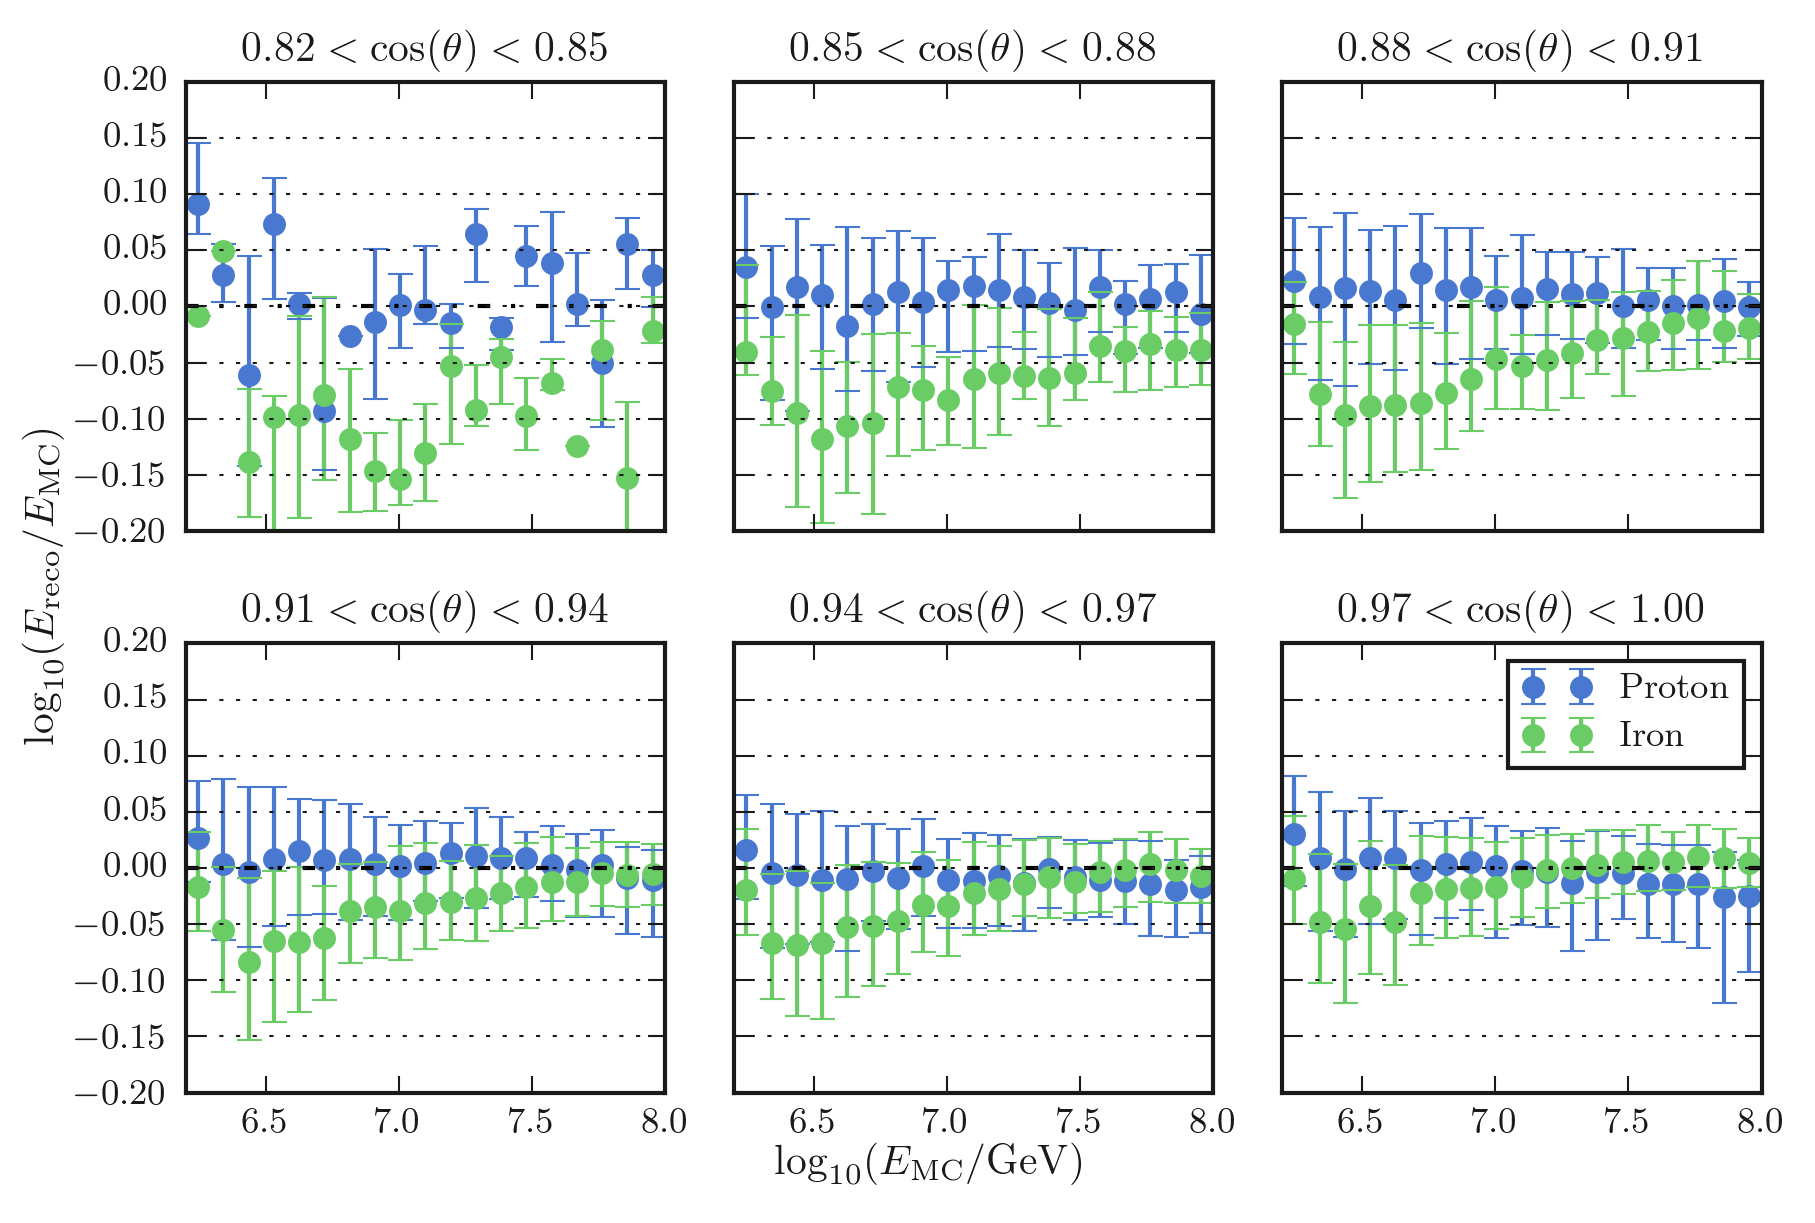

In [13]:
LLH_bins = ShowerLLH.LLHBins('logdist')
zbins = LLH_bins.bins['Z']
cos_zbins = np.cos(zbins)[::-1]
cos_zbins = cos_zbins[3:]
print(cos_zbins)
d_cosz = (cos_zbins[1:] - cos_zbins[:-1])
fig, axarr = plt.subplots(2, 3, sharey=True, sharex=True)
for cosz, ax in zip(cos_zbins[:-1], axarr.flat):
    MC_proton_mask = (df['MC_comp'] == 'P').values
    MC_iron_mask = (df['MC_comp'] == 'Fe').values
    zenith_mask = (np.cos(df['lap_zenith'].values) > cosz) & (np.cos(df['lap_zenith'].values) < cosz + 0.02924444)
    MC_log_energy = df.MC_log_energy.values
    reco_log_energy = df.lap_log_energy.values
    energy_res = reco_log_energy - MC_log_energy
    energy_bins = np.linspace(6.2, 8, 20)
    bin_centers, bin_medians_proton, error_proton = comp.analysis.data_functions.get_medians(
                                                        MC_log_energy[MC_proton_mask & zenith_mask],
                                                        energy_res[MC_proton_mask & zenith_mask],
                                                        energy_bins)
    bin_centers, bin_medians_iron, error_iron = comp.analysis.data_functions.get_medians(MC_log_energy[MC_iron_mask & zenith_mask],
                                                                                         energy_res[MC_iron_mask & zenith_mask],
                                                                                         energy_bins)
    ax.errorbar(bin_centers, bin_medians_proton, yerr=error_proton, marker='.', label='Proton', alpha=1.0)
    ax.errorbar(bin_centers, bin_medians_iron, yerr=error_iron, marker='.', label='Iron', alpha=1.0)
    ax.axhline(0, marker='None', linestyle='-.')
    ax.set_title('${:.2f} < \cos(\\theta) < {:.2f}$'.format(cosz, cosz + 0.02924444))
    ax.set_ylim([-0.2, 0.2])
#     ax2 = ax.twinx()
# #     ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
#     ax2.set_ylim(list(ax.get_ylim()))
#     # ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
#     # ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
#     plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
    ax.yaxis.grid()
#     plt.show()
#     ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
#     ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
fig.text(0.00, 0.5, '$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$', va='center', rotation='vertical')
# fig.text(1.0, 0.5, '$E_{\mathrm{reco}}/E_{\mathrm{MC}}$', va='center', rotation='vertical')
fig.text(0.5, 0.00, '$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$', ha='center')
plt.ylim([-0.2, 0.2])
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
MC_x = df.MC_x
MC_y = df.MC_y
reco_x = df.reco_x
reco_y = df.reco_y
lap_x = df.lap_x
lap_y = df.lap_y

In [31]:
core_res = np.sqrt((reco_x - MC_x)**2+(reco_y - MC_y)**2)
lap_core_res = np.sqrt((lap_x - MC_x)**2+(lap_y - MC_y)**2)
bin_centers, reco_bin_medians, reco_error = comp.analysis.get_medians(MC_log_energy, core_res, energy_bins)
bin_centers, lap_bin_medians, lap_error = comp.analysis.get_medians(MC_log_energy, lap_core_res, energy_bins)

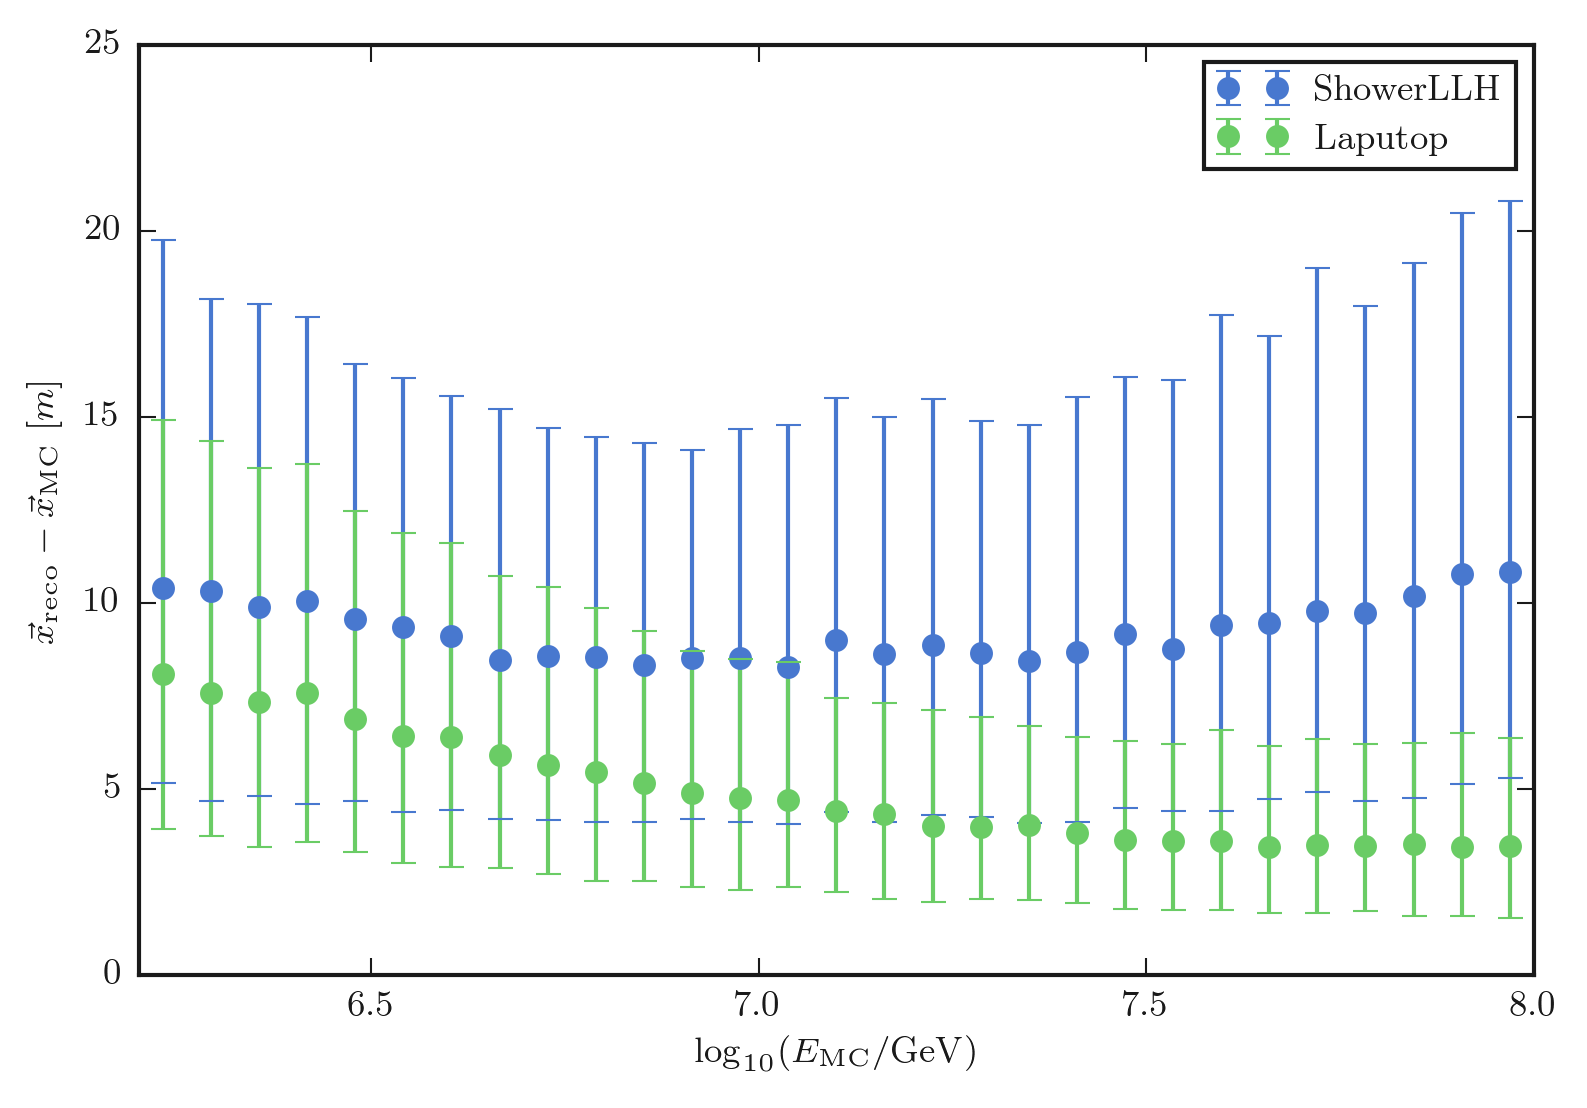

In [33]:
fig, ax = plt.subplots()
ax.errorbar(bin_centers, reco_bin_medians, yerr=reco_error, marker='.', label='ShowerLLH', alpha=1.0)
ax.errorbar(bin_centers, lap_bin_medians, yerr=lap_error, marker='.', label='Laputop', alpha=1.0)
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\\vec{x}_{\mathrm{reco}}-\\vec{x}_{\mathrm{MC}} \ [m]$')
plt.legend()
plt.show()

In [42]:
reco_core_pos = np.sqrt(MC_x**2+MC_y**2)
pos_bins = np.linspace(0, 800, 40)
LLH_log_energy = df.reco_log_energy.values
energy_res_LLH = LLH_log_energy - MC_log_energy

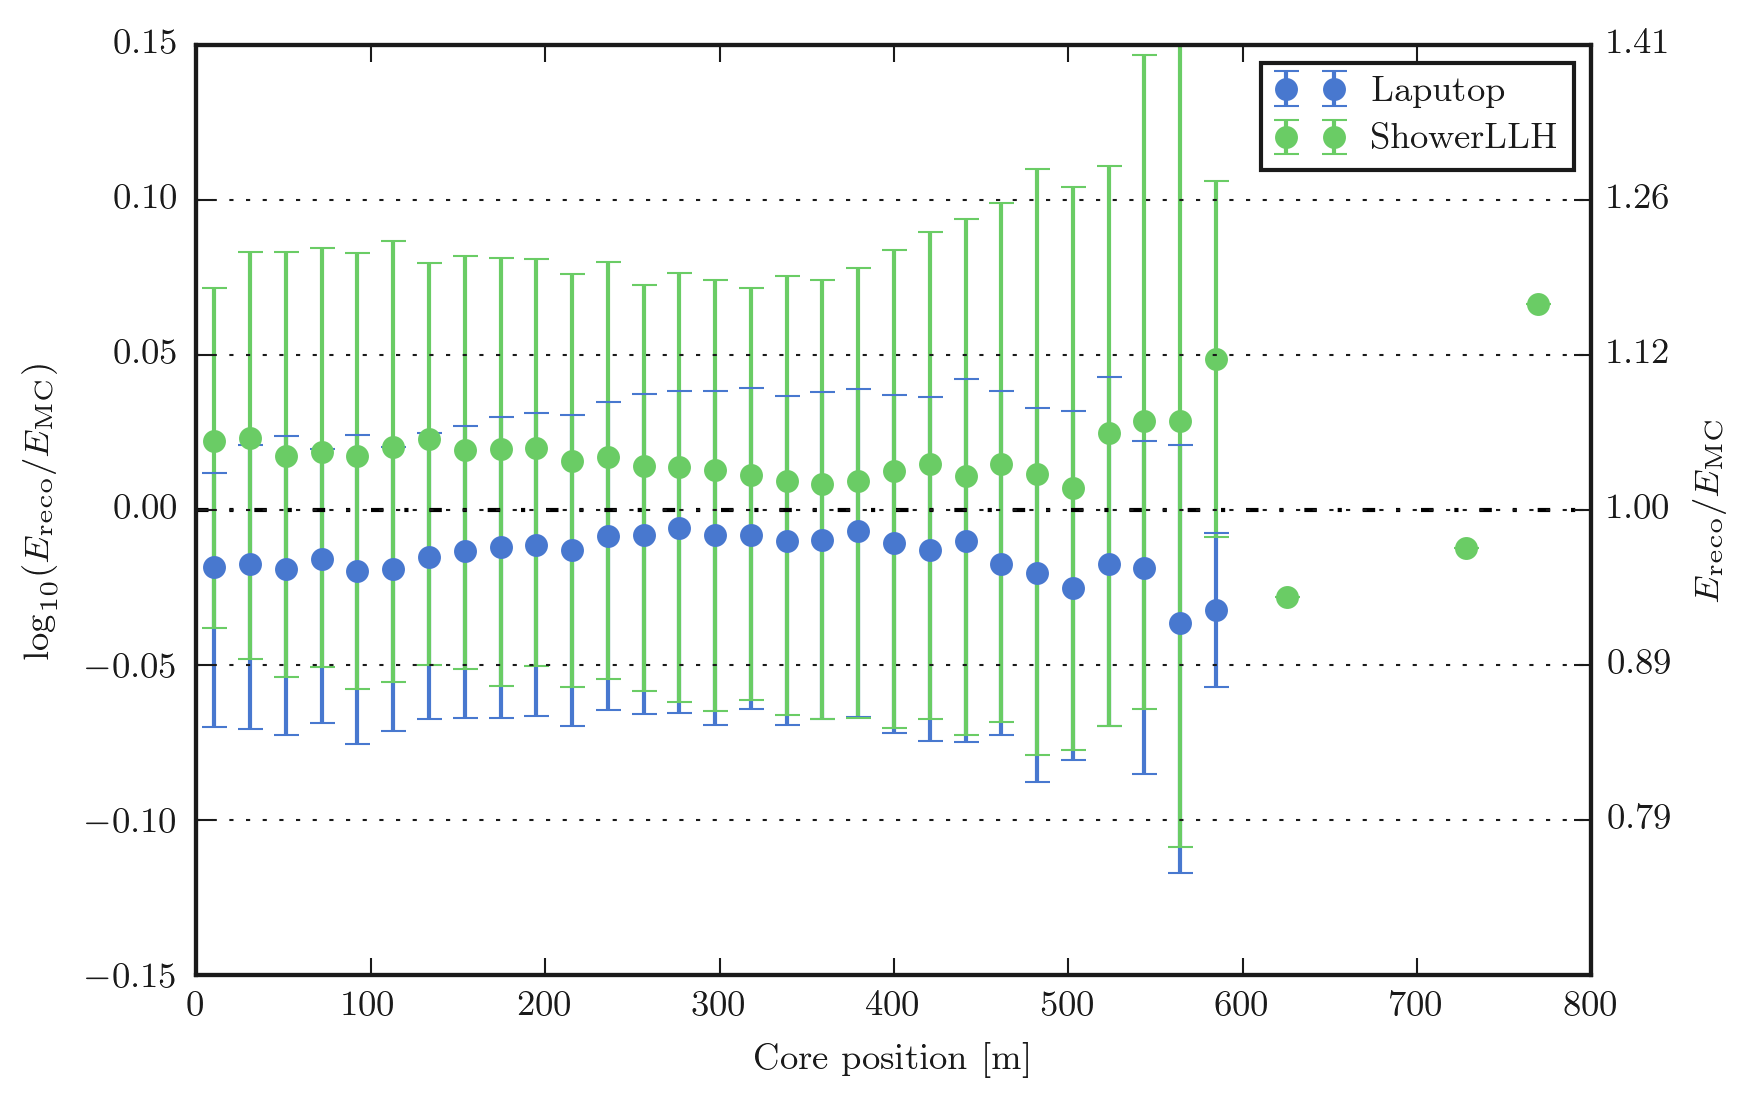

In [51]:
fig, ax = plt.subplots()
bin_centers, bin_medians, error = comp.analysis.get_medians(reco_core_pos, energy_res, pos_bins)
ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', label='Laputop')
bin_centers, bin_medians, error = comp.analysis.get_medians(reco_core_pos, energy_res_LLH, pos_bins)
ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', label='ShowerLLH')
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('Core position [m]')
ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
ax.set_ylim([-0.15, 0.15])
ax.yaxis.grid()
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
ax2.set_ylim(list(ax.get_ylim()))
plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.show()

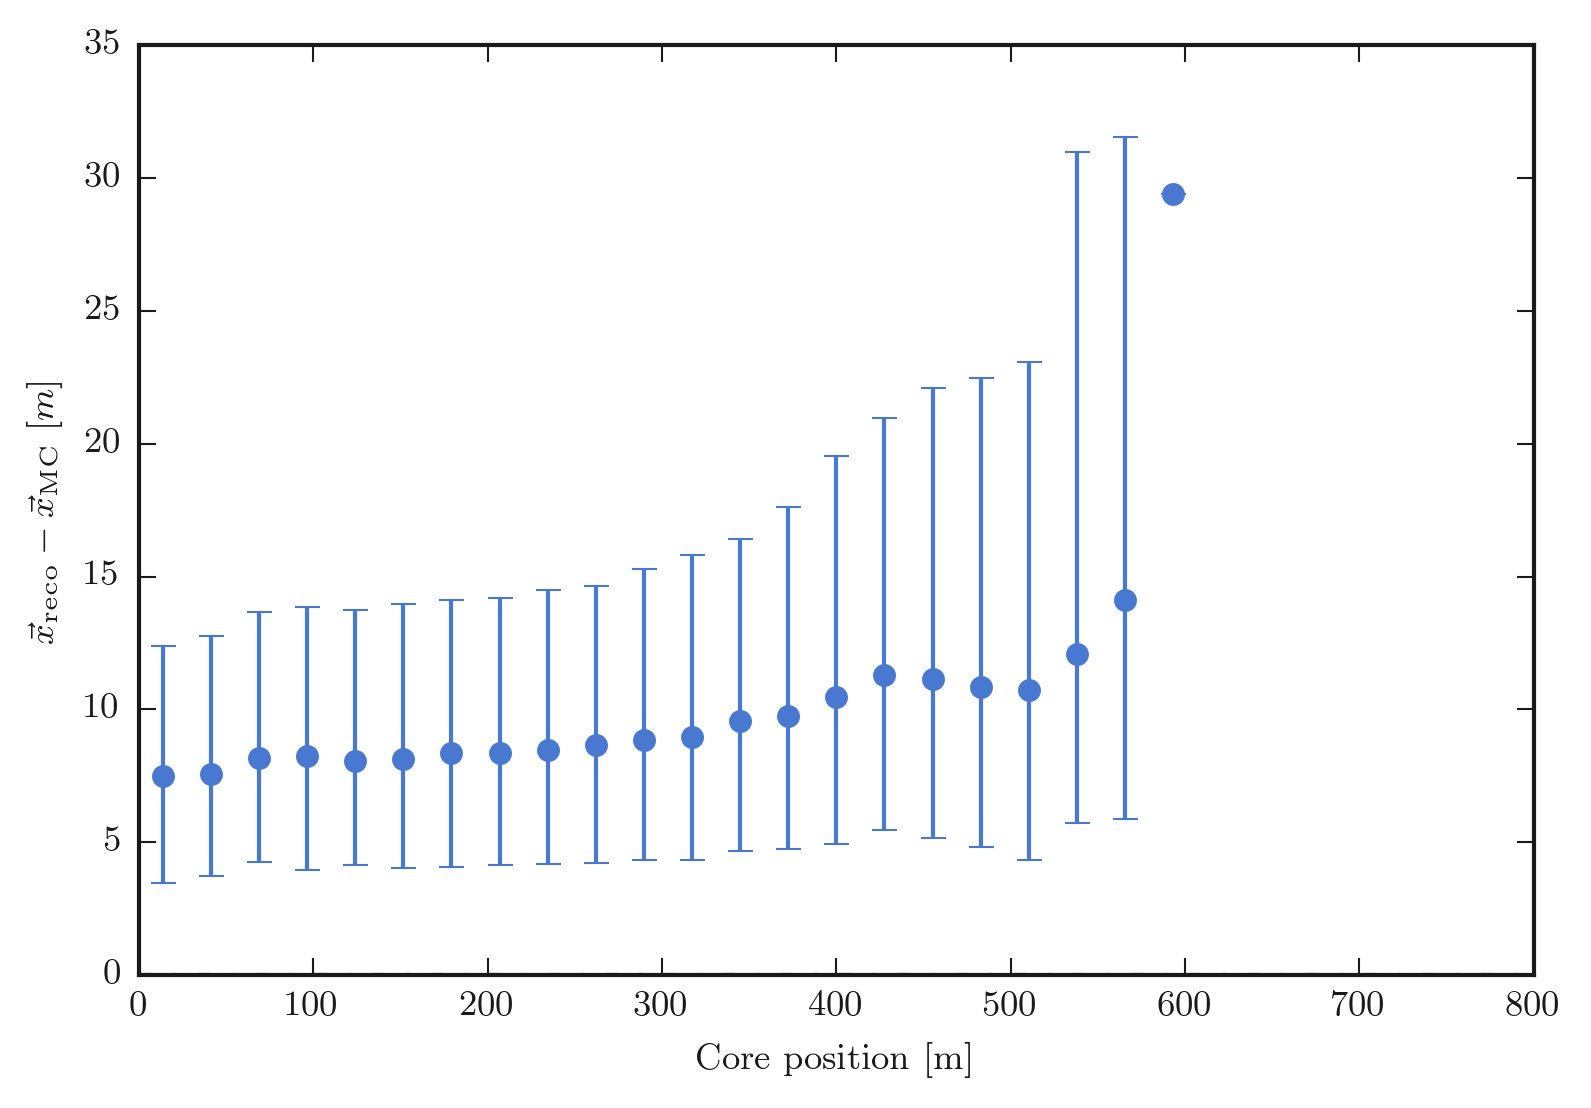

In [47]:
reco_core_pos = np.sqrt(MC_x**2+MC_y**2)
pos_bins = np.linspace(0, 800, 30)
bin_centers, bin_medians, error = comp.analysis.get_medians(reco_core_pos, core_res, pos_bins)
fig, ax = plt.subplots()
ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.')
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('Core position [m]')
ax.set_ylabel('$\\vec{x}_{\mathrm{reco}}-\\vec{x}_{\mathrm{MC}} \ [m]$')
plt.show()

In [18]:
LLH_grid = ShowerLLH.LLHGrid('7006')
tank_xy = LLH_grid.tank_xy
tank_x, tank_y = np.transpose(tank_xy)

Loading /data/ana/CosmicRay/IceTop_level3/sim/IC79/GCD/Level3_7006_GCD.i3.gz...


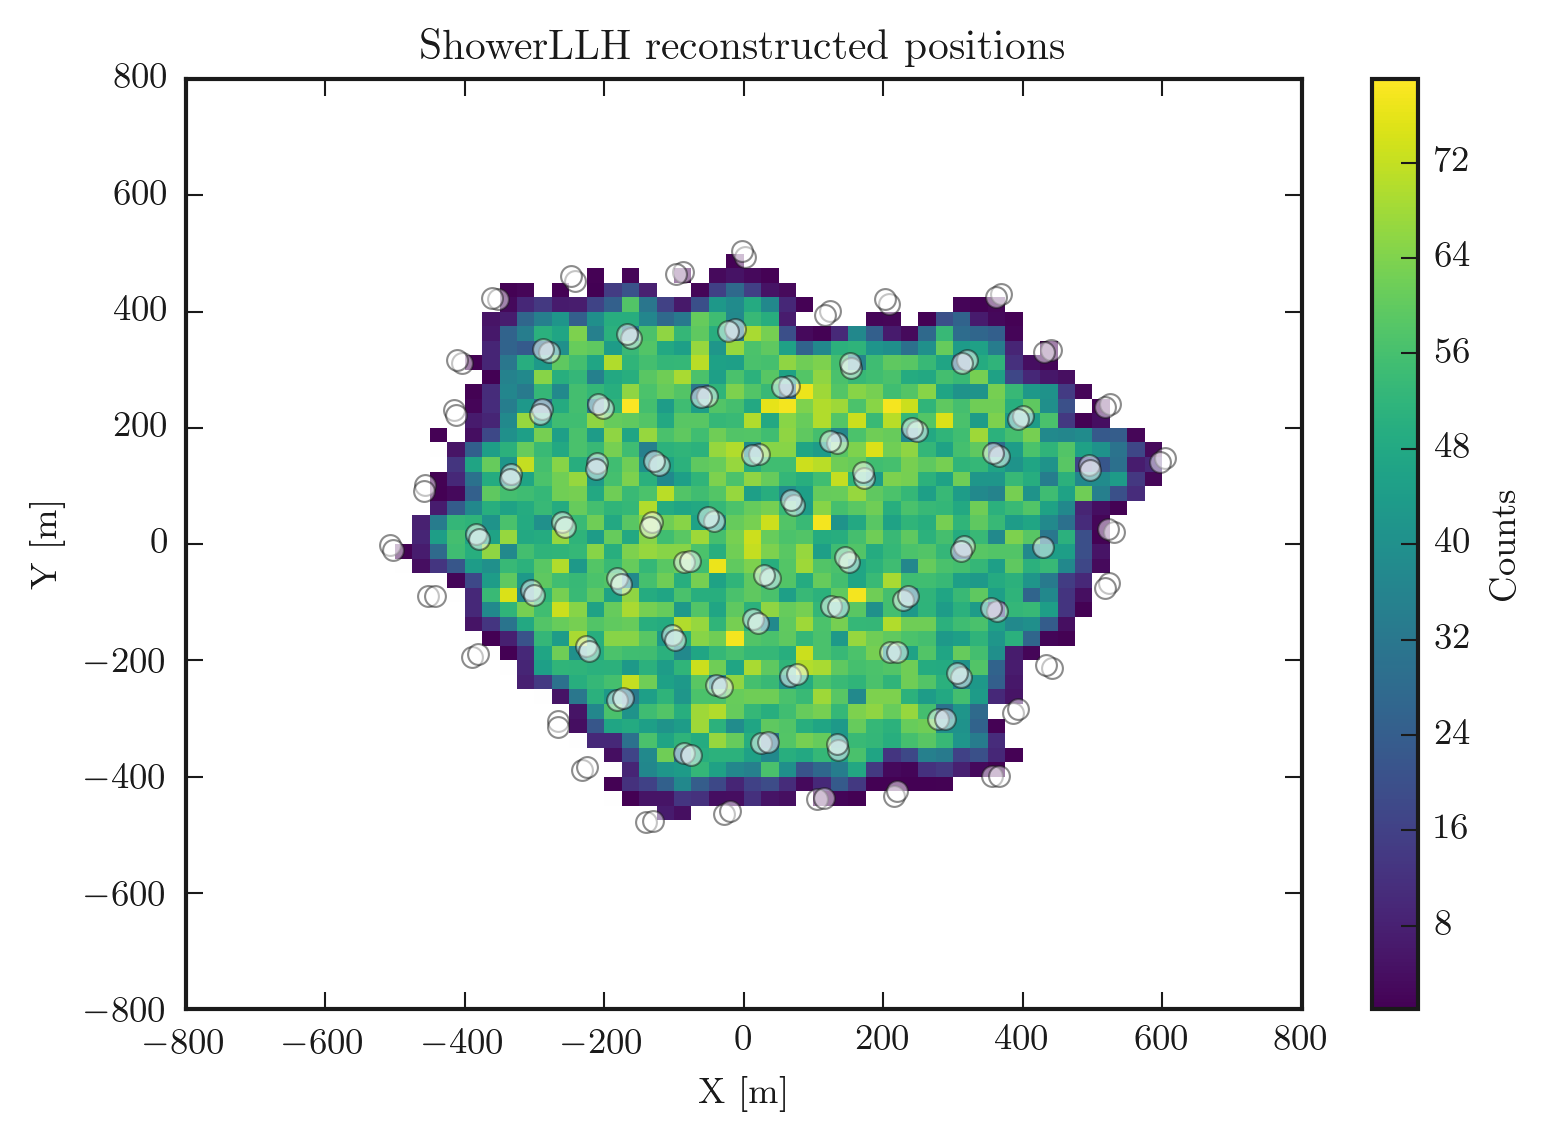

In [19]:
dist_bins = np.arange(-1700, 1700, 25)
fig, ax = plt.subplots()
plotting.histogram_2D(reco_x, reco_y, dist_bins)
ax.plot(tank_x, tank_y, marker='o', markersize=5,
        color='white', alpha=0.5)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('ShowerLLH reconstructed positions')
ax.set_xlim([-800,800])
ax.set_ylim([-800,800])
plt.show()

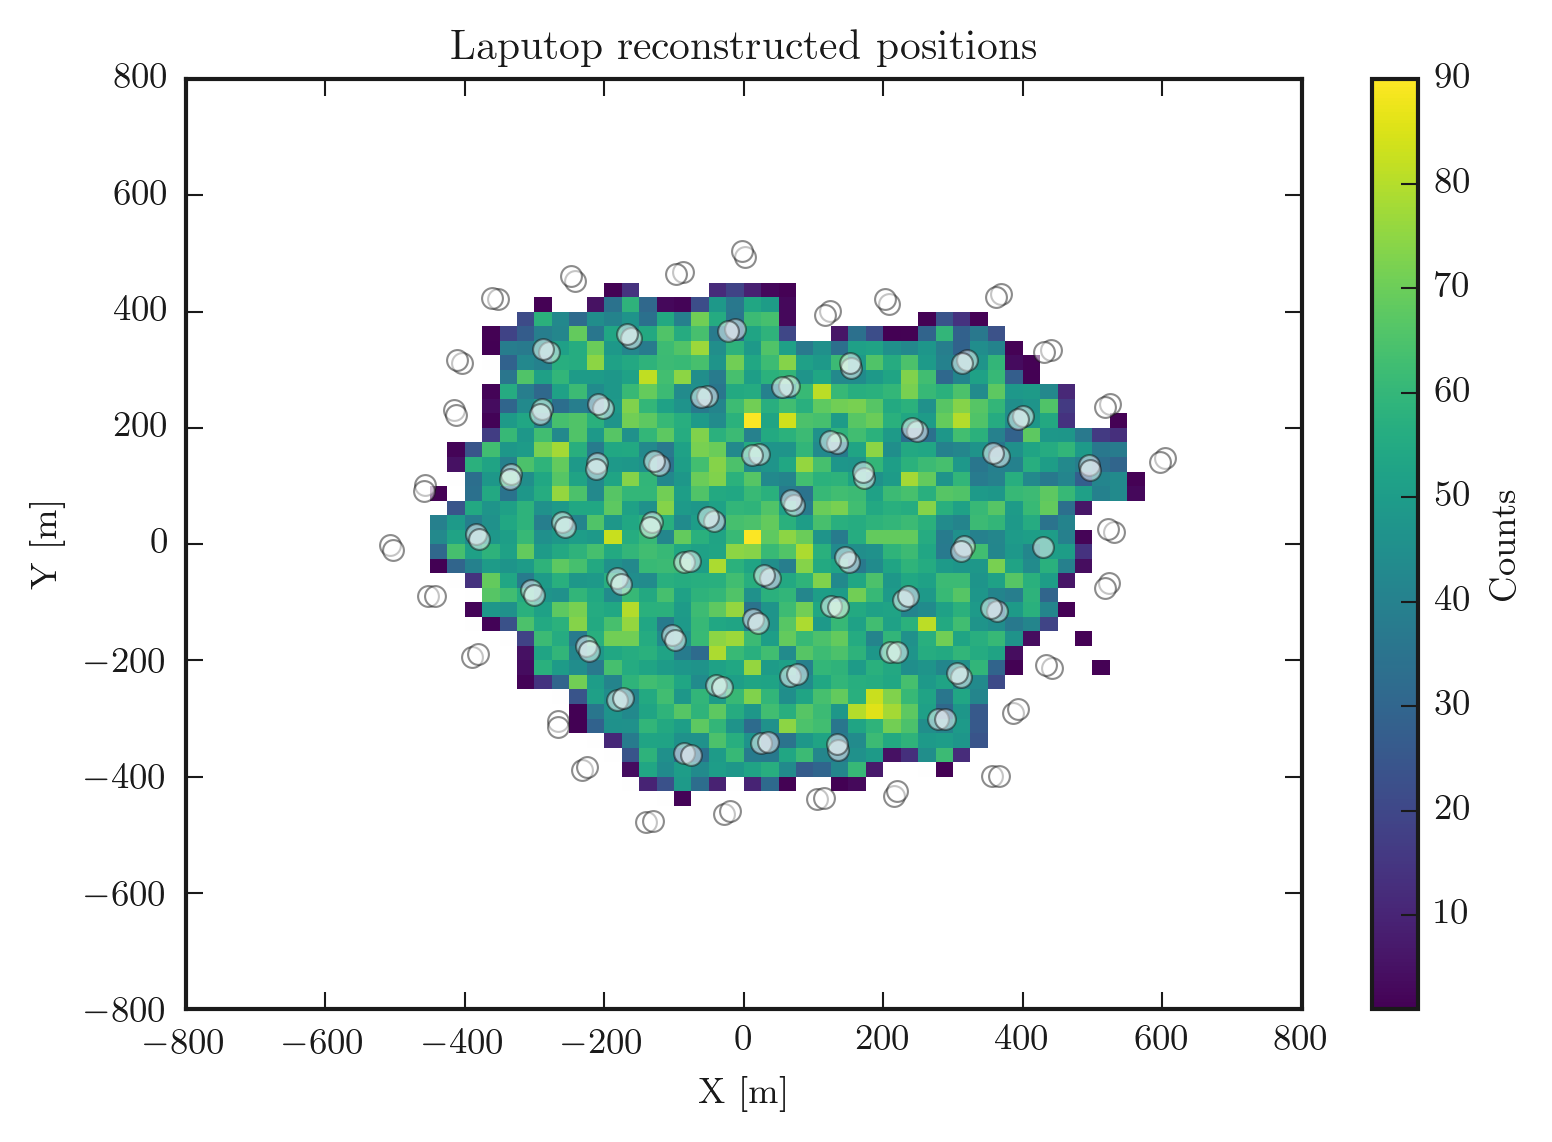

In [20]:
fig, ax = plt.subplots()
plotting.histogram_2D(lap_x, lap_y, dist_bins)
ax.plot(tank_x, tank_y, marker='o', markersize=5,
        color='white', alpha=0.5)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Laputop reconstructed positions')
ax.set_xlim([-800,800])
ax.set_ylim([-800,800])
plt.show()

In [21]:
df_lap, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df_lap))
standard_cut_keys = ['LLHlap_reco_exists', 'LLHlap_zenith', 'num_hits_1_60', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_60', 'LLHlap_containment',
                     'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

print('n_events before cuts = {}'.format(len(df_lap)))
df_lap = df_lap[selection_mask]
print('n_events after cuts = {}'.format(len(df_lap)))

df_LF, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df_LF))
standard_cut_keys = ['LLHLF_reco_exists', 'LLHLF_zenith', 'num_hits_1_60', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_60', 'LLHLF_containment',
                     'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

print('n_events before cuts = {}'.format(len(df_LF)))
df_LF = df_LF[selection_mask]
print('n_events after cuts = {}'.format(len(df_LF)))

df_LLH, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df_LLH))
standard_cut_keys = ['ShowerLLH_reco_exists', 'ShowerLLH_zenith', 'num_hits_1_60', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_60', 'reco_containment',
                     'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

print('n_events before cuts = {}'.format(len(df_LLH)))
df_LLH = df_LLH[selection_mask]
print('n_events after cuts = {}'.format(len(df_LLH)))

n_events before cuts = 441798
n_events after cuts = 51608
n_events before cuts = 441798
n_events after cuts = 40081
n_events before cuts = 441798
n_events after cuts = 52230


In [22]:
LLHlap_zenith = df_lap['LLHlap_zenith'].values
MC_zenith_lap = df_lap['MC_zenith'].values
MC_energy_lap = df_lap['MC_log_energy'].values

LLHLF_zenith = df_LF['LLHLF_zenith'].values
MC_zenith_LF = df_LF['MC_zenith'].values
MC_energy_LF = df_LF['MC_log_energy'].values

LLH_zenith = np.pi - df_LLH['reco_zenith'].values
MC_zenith_LLH = df_LLH['MC_zenith'].values
MC_energy_LLH = df_LLH['MC_log_energy'].values

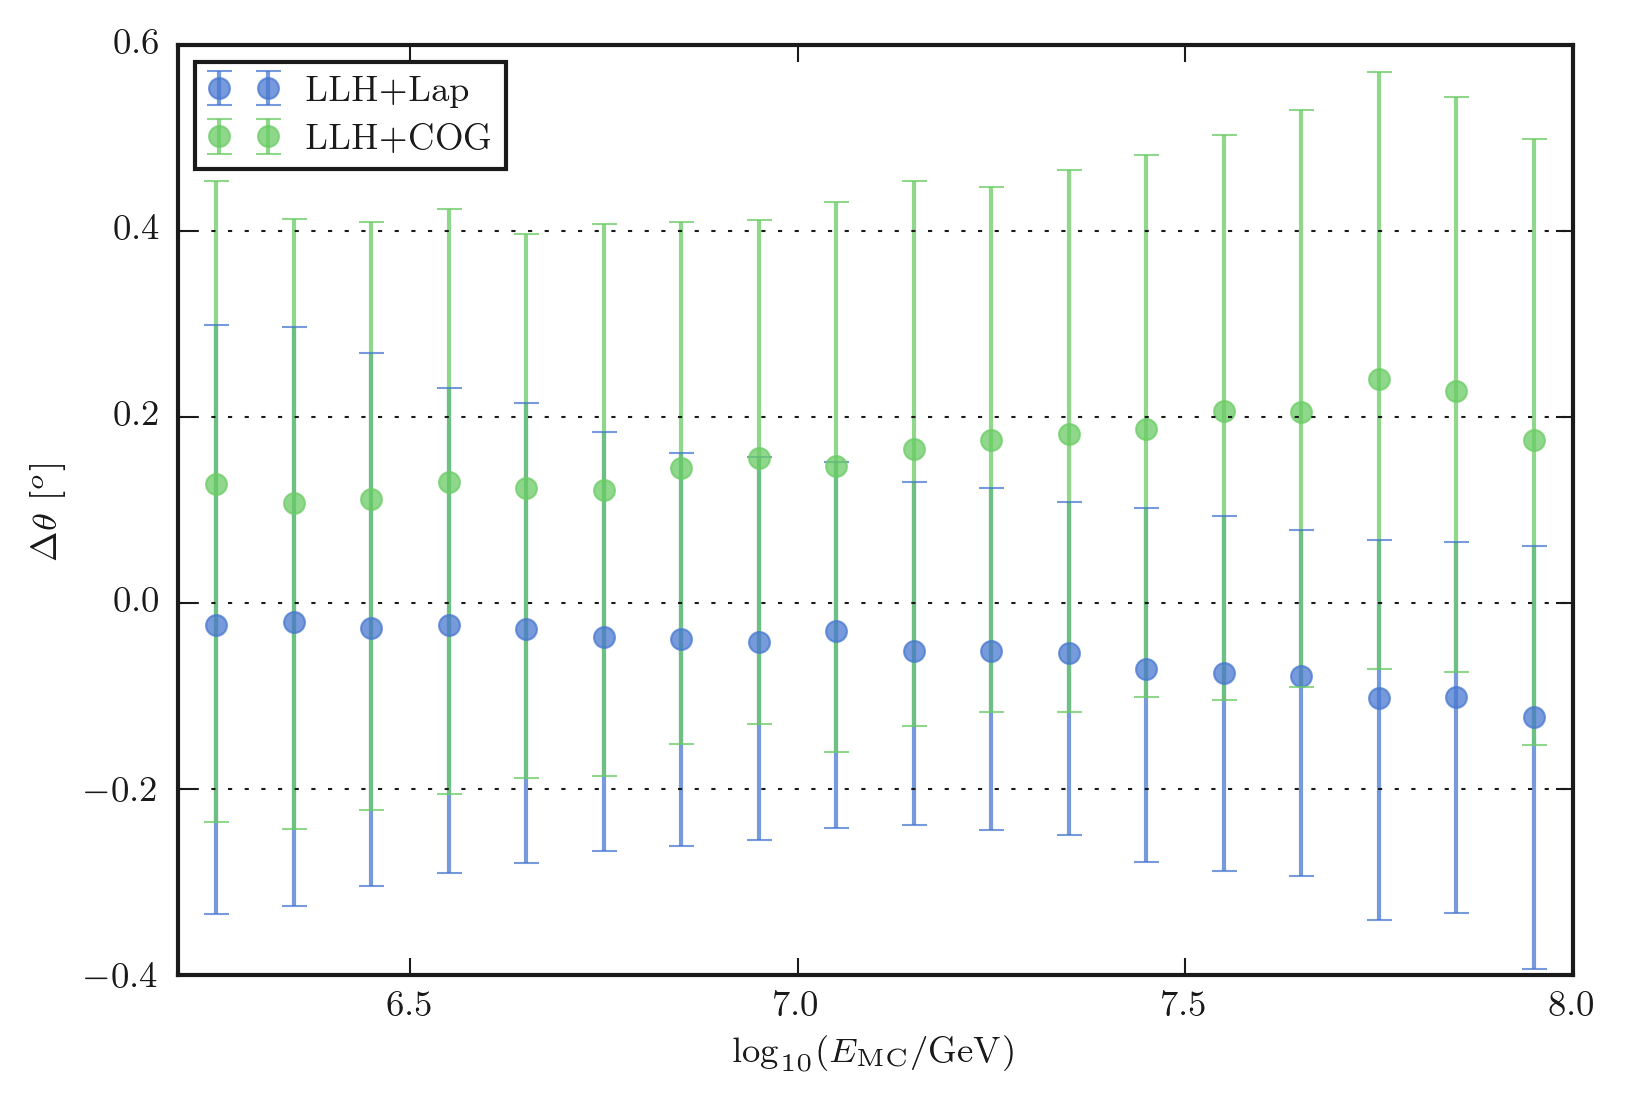

In [23]:
fig, ax = plt.subplots()
zenith_res_lap = (LLHlap_zenith - MC_zenith_lap)*180/np.pi
zenith_res_LF = (LLHLF_zenith - MC_zenith_LF)*180/np.pi
zenith_res_LLH = (LLH_zenith - MC_zenith_LLH)*180/np.pi
energy_bins = np.arange(6.2, 8.1, 0.1)
bin_centers, bin_medians_lap, error_lap = comp.analysis.get_medians(MC_energy_lap, zenith_res_lap, energy_bins)
ax.errorbar(bin_centers, bin_medians_lap, yerr=error_lap, marker='.', label='LLH+Lap', alpha=0.75)
bin_centers, bin_medians_LF, error_LF = comp.analysis.get_medians(MC_energy_LF, zenith_res_LF, energy_bins)
ax.errorbar(bin_centers, bin_medians_LF, yerr=error_LF, marker='.', label='LLH+COG', alpha=0.75)
# bin_centers, bin_medians_LLH, error_LLH = comp.analysis.get_medians(MC_energy_LLH, zenith_res_LLH, energy_bins)
# ax.errorbar(bin_centers, bin_medians_LLH, yerr=error_LLH, marker='.', label='ShowerPlane', alpha=0.75)
ax.set_ylabel('$\Delta \\theta \ [^o]$')
# ax.set_ylabel('$\\theta_{\mathrm{reco}}/\\theta_{\mathrm{MC}}$')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.legend(loc=2)
ax.yaxis.grid()
plt.show()

In [24]:
core_pos_lap = df_lap['reco_radius'].values
core_pos_LF = df_LF['reco_radius'].values
core_pos_LLH = df_LLH['reco_radius'].values

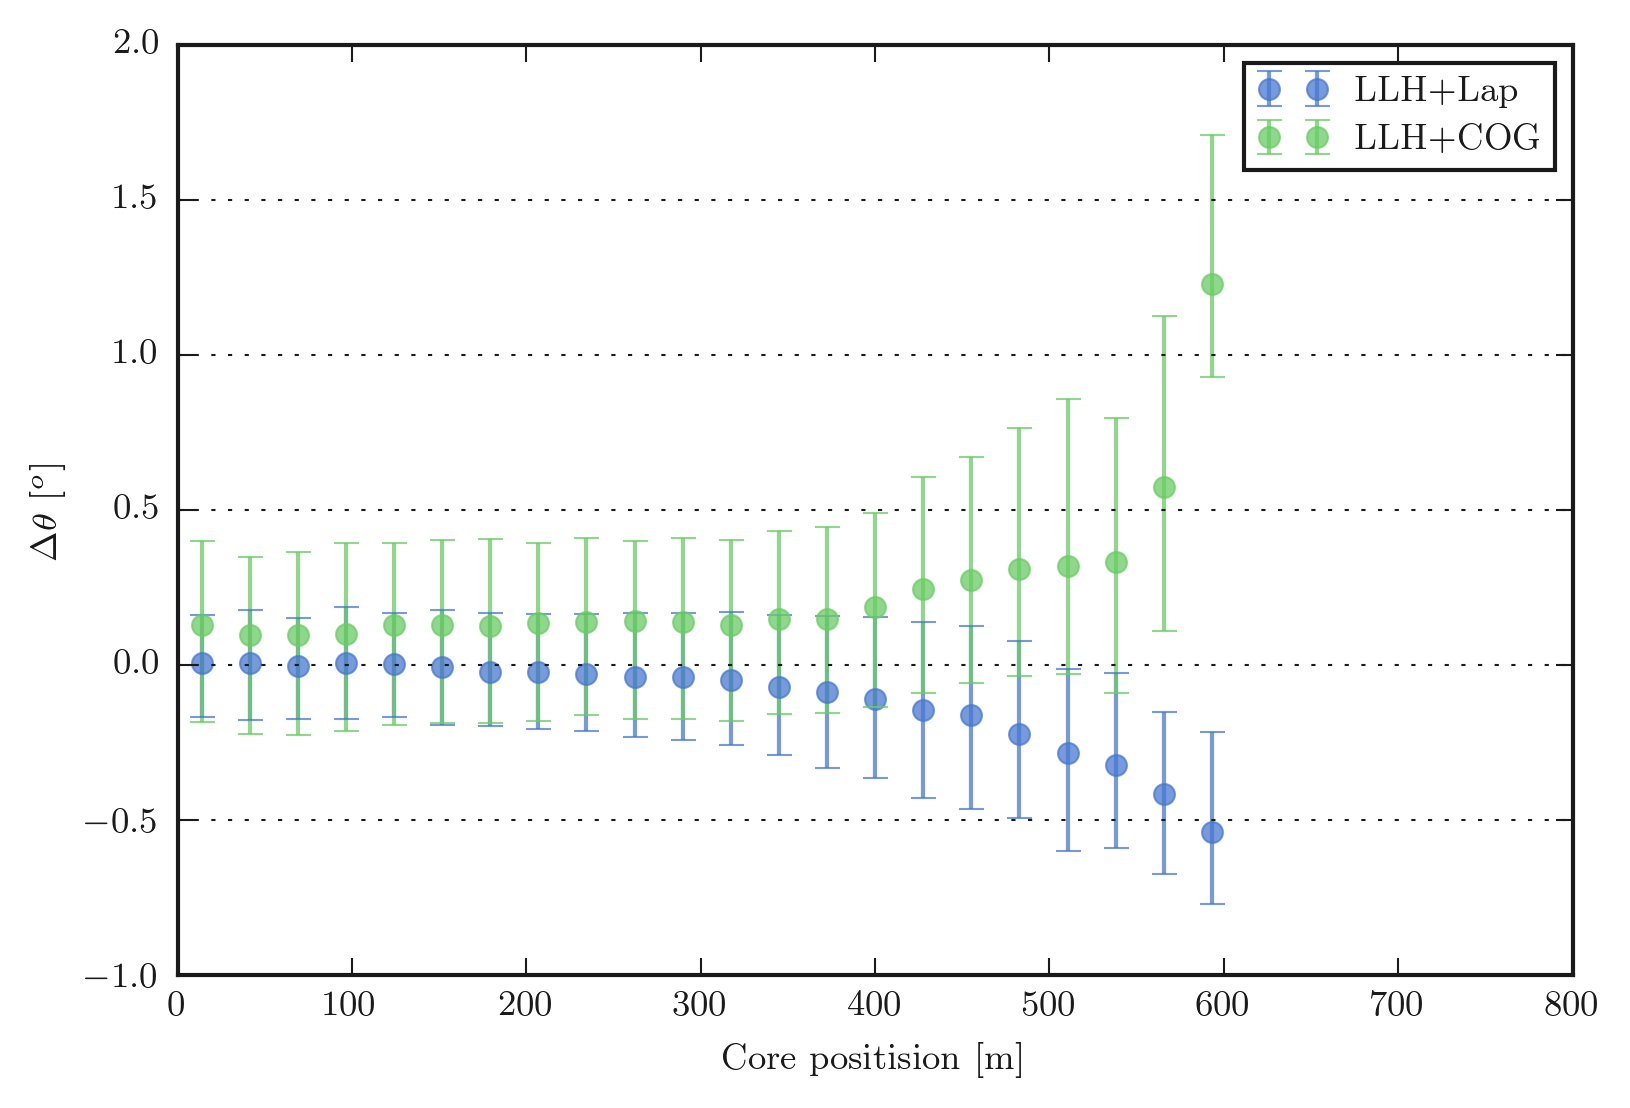

In [26]:
fig, ax = plt.subplots()
zenith_res_lap = (LLHlap_zenith - MC_zenith_lap)*180/np.pi
zenith_res_LF = (LLHLF_zenith - MC_zenith_LF)*180/np.pi
pos_bins = np.linspace(0, 800, 30)
bin_centers, bin_medians_lap, error_lap = comp.analysis.get_medians(core_pos_lap, zenith_res_lap, pos_bins)
ax.errorbar(bin_centers, bin_medians_lap, yerr=error_lap, marker='.', label='LLH+Lap', alpha=0.75)
bin_centers, bin_medians_LF, error_LF = comp.analysis.get_medians(core_pos_LF, zenith_res_LF, pos_bins)
ax.errorbar(bin_centers, bin_medians_LF, yerr=error_LF, marker='.', label='LLH+COG', alpha=0.75)
# bin_centers, bin_medians_LLH, error_LLH = comp.analysis.get_medians(core_pos_LLH, zenith_res_LLH, pos_bins)
# ax.errorbar(bin_centers, bin_medians_LLH, yerr=error_LLH, marker='.', label='ShowerPlane', alpha=0.75)
ax.set_ylabel('$\Delta \\theta \ [^o]$')
# ax.set_ylabel('$\\theta_{\mathrm{reco}}/\\theta_{\mathrm{MC}}$')
ax.set_xlabel('Core positision [m]')
ax.legend()
ax.yaxis.grid()
plt.show()